In [76]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Sequence
from dotenv import load_dotenv
from langchain_ollama import ChatOllama
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
import os

load_dotenv()

llm = ChatOllama(model="mistral:latest")

In [77]:
load_dotenv()

True

In [78]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [79]:
@tool
def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers"""
    return a - b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b

@tool
def divide(a: int, b: int) -> int:
    """Divide two numbers"""
    if b == 0:
        return "Error: Division by zero"
    return a / b

In [80]:
my_tools = [add, subtract, multiply, divide]

# Bind tools so the model can call them (use this llm in model_call)
llm = llm.bind_tools(my_tools)

In [81]:
def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content="""
    You are a helpful AI assistant. You MUST call the provided tools for any arithmetic.
    Do not write code, pseudo-code, or describe the steps—actually invoke the add, subtract,
    multiply, or divide tool with the correct arguments. Use the tool results in your final answer.
    Never compute numbers yourself or use your reasoning.
    """)
 
    inputs = [system_prompt] + state["messages"]

    res = llm.invoke(inputs)
    return {"messages": state["messages"] + [res]}


def should_continue(state: AgentState) -> str:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "continue"
    else:
        return "end"
        

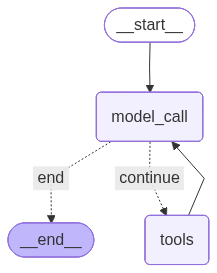

In [82]:
tool_node = ToolNode(my_tools)

graph = StateGraph(AgentState)
graph.add_node("model_call", model_call)
graph.add_node("tools", tool_node)

graph.add_edge(START, "model_call")
graph.add_conditional_edges("model_call", should_continue, {"continue": "tools", "end": END})

graph.add_edge("tools", "model_call")
graph.add_edge("model_call", END)

g= graph.compile()
g

In [83]:
def print_stream(stream):
    for s in stream:
        node_name, node_values = next(iter(s.items()))
        if "messages" not in node_values:
            continue
        # node_values["messages"] can be a list of new messages from this node
        for message in node_values["messages"]:
            if isinstance(message, tuple):
                print(message)
            elif isinstance(message, ToolMessage):
                print("[TOOL RESULT]", message.name or "tool", "->", message.content)
                message.pretty_print()
            elif isinstance(message, AIMessage):
                print("[LLM]")
                if getattr(message, "tool_calls", None):
                    print("  -> tool_calls:", [(tc.get("name"), tc.get("args")) for tc in message.tool_calls])
                message.pretty_print()
            else:
                message.pretty_print()


In [84]:
# messages must be a list of BaseMessage (e.g. HumanMessage), not a set or dict
input = {"messages": [HumanMessage(content="add 2 and 5 and calculate the product with 6. also tell me a joke at the end")]}

print_stream(g.stream(input))

================================ Human Message =================================

add 2 and 5 and calculate the product with 6. also tell me a joke at the end
[LLM]
  -> tool_calls: [('add', {'a': 2, 'b': 5})]
================================== Ai Message ==================================
Tool Calls:
  add (41a4b8db-6771-4ae8-8ce2-0e1b60a4e813)
 Call ID: 41a4b8db-6771-4ae8-8ce2-0e1b60a4e813
  Args:
    a: 2
    b: 5
[TOOL RESULT] add -> 7
================================= Tool Message =================================
Name: add

7
================================ Human Message =================================

add 2 and 5 and calculate the product with 6. also tell me a joke at the end
[LLM]
  -> tool_calls: [('add', {'a': 2, 'b': 5})]
================================== Ai Message ==================================
Tool Calls:
  add (41a4b8db-6771-4ae8-8ce2-0e1b60a4e813)
 Call ID: 41a4b8db-6771-4ae8-8ce2-0e1b60a4e813
  Args:
    a: 2
    b: 5
[TOOL RESULT] add -> 7
==================